In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!unzip data/EVChargingStationUsage.zip -d data/

Archive:  data/EVChargingStationUsage.zip
replace data/EVChargingStationUsage.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/EVChargingStationUsage.csv  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime

df = pd.read_csv('data/EVChargingStationUsage.csv')

<ipython-input-24-c987f7aea82e>:8: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/EVChargingStationUsage.csv')


In [ ]:
df.head(10)

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,03:03:32,01:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,00:02:06,00:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,04:17:32,04:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,02:03:24,02:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,01:11:24,00:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN
5,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 21:38,PDT,7/31/2011 1:30,PDT,7/31/2011 1:30,03:52:13,01:30:58,...,-122.160309,NaN,0.0,Plug Out at Vehicle,8,94065.0,5144.0,NaN,NaN,NaN
6,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/31/2011 4:33,PDT,7/31/2011 10:40,PDT,7/31/2011 10:40,06:06:19,04:56:47,...,-122.160309,USD,0.0,Customer,9,94301.0,4447.0,NaN,NaN,NaN
7,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/31/2011 12:25,PDT,7/31/2011 13:35,PDT,7/31/2011 13:35,01:09:54,01:09:49,...,-122.160309,USD,0.0,Plug Out at Vehicle,10,94301.0,4169.0,NaN,NaN,NaN
8,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/31/2011 17:41,PDT,7/31/2011 22:31,PDT,7/31/2011 22:31,04:49:46,04:41:16,...,-122.160309,USD,0.0,Customer,11,94301.0,4447.0,NaN,NaN,NaN
9,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,08-01-2011 19:11,PDT,08-01-2011 22:34,PDT,08-01-2011 22:34,03:23:34,01:35:08,...,-122.160309,USD,0.0,Plug Out at Vehicle,13,94303.0,4440.0,NaN,NaN,NaN


# Convert Start Date and End Date to UTC

Remove those forms in date isn't correct and then converting the correct dates to UTC format.(There are some rows which has date something like 1243.3434)

In [ ]:
print(df['Start Time Zone'].unique())
print(df['End Time Zone'].unique())

['PDT' 'PST' 'UTC']
['PDT' 'PST' 'UTC']


In [ ]:
def convert_to_utc_start(row):
    try:
        # Try parsing with '/' format first
        dt = datetime.strptime(row['Start Date'], "%m/%d/%Y %H:%M")
    except ValueError:
        # If parsing with '/' format fails, use '-' format
        dt = datetime.strptime(row['Start Date'], "%m-%d-%Y %H:%M")

    tz = (
        pytz.timezone('America/Los_Angeles')
        if row['Start Time Zone'] in ('PDT', 'PST')
        else pytz.timezone('UTC')
    )

    return tz.localize(dt).astimezone(pytz.utc)


def convert_to_utc_end(row):
    try:
        # Try parsing with '/' format first
        dt = datetime.strptime(row['End Date'], "%m/%d/%Y %H:%M")
    except ValueError:
        # If parsing with '/' format fails, use '-' format
        dt = datetime.strptime(row['End Date'], "%m-%d-%Y %H:%M")

    tz = (
        pytz.timezone('America/Los_Angeles')
        if row['End Time Zone'] in ('PDT', 'PST')
        else pytz.timezone('UTC')
    )

    return tz.localize(dt).astimezone(pytz.utc)


date_format_1 = r'(\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{1,2})'
date_format_2 = r'(\d{1,2}-\d{1,2}-\d{4} \d{1,2}:\d{1,2})'

valid_start_date = df['Start Date'].str.match(date_format_1) | df['Start Date'].str.match(date_format_2)
valid_end_date = df['End Date'].str.match(date_format_1) | df['End Date'].str.match(date_format_2)

df = df[valid_start_date & valid_end_date]


df['Start Date'] = df.apply(convert_to_utc_start, axis=1)
df['End Date'] = df.apply(convert_to_utc_end, axis=1)


In [ ]:
print(df.shape)
df.head()

(259375, 34)


,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number,Year
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2011-07-30 03:17:00+00:00,PDT,2011-07-30 06:20:00+00:00,PDT,7/29/2011 23:20,03:03:32,01:54:03,...,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN,2011
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2011-07-30 07:00:00+00:00,PDT,2011-07-30 07:02:00+00:00,PDT,7/30/2011 0:02,00:02:06,00:01:54,...,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN,2011
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2011-07-30 15:16:00+00:00,PDT,2011-07-30 19:34:00+00:00,PDT,7/30/2011 12:34,04:17:32,04:17:28,...,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN,2011
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2011-07-30 21:51:00+00:00,PDT,2011-07-30 23:55:00+00:00,PDT,7/30/2011 16:55,02:03:24,02:02:58,...,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN,2011
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2011-07-31 01:51:00+00:00,PDT,2011-07-31 03:03:00+00:00,PDT,7/30/2011 20:03,01:11:24,00:43:54,...,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN,2011


# Plotting different Year-Wise trends

# 1. Energy Consumption for each year
The figure below shows the quantity of energy consumed every year, with the exception of 2018 and 2020. People tended to stay at home during the covid pandemic (2020) . The number of forest fires that occurred in California in 2018 may have made gasoline more affordable, which might have led to a decrease in the use of EVs in that year.

We observe similar trends for GHG savings,Gasoline Savings and number of unique EV users per year.

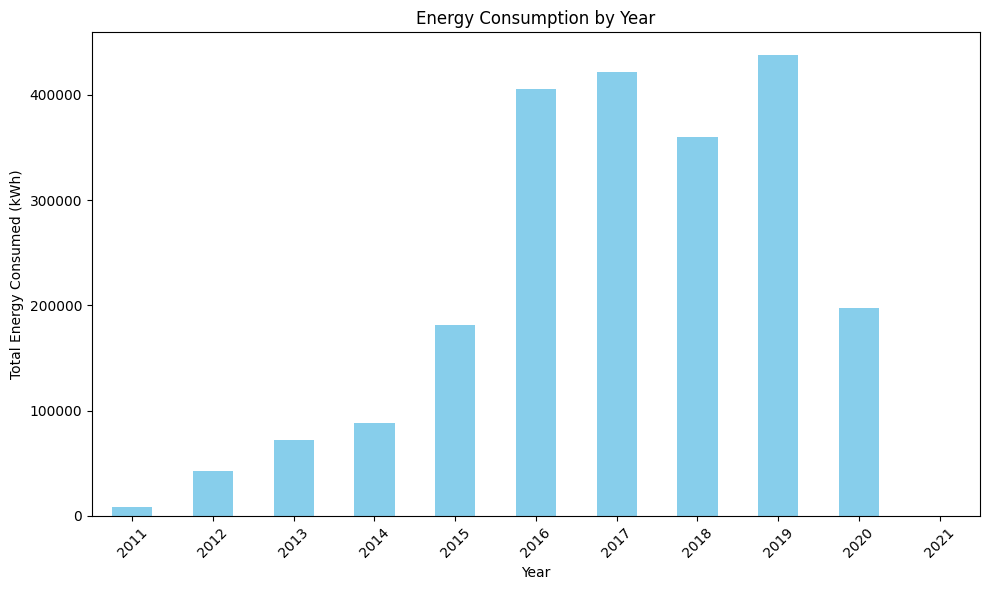

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df['Start Date'] = pd.to_datetime(df['Start Date'], format='%m/%d/%Y %H:%M', errors='coerce')
df['Start Date'] = df['Start Date'].combine_first(pd.to_datetime(df['Start Date'], format='%m-%d-%Y %H:%M:%S', errors='coerce'))


df['Year'] = df['Start Date'].dt.year


energy_savings_by_year = df.groupby('Year')['Energy (kWh)'].sum()


plt.figure(figsize=(10, 6))
energy_savings_by_year.plot(kind='bar', color='skyblue')
plt.title('Energy Consumption by Year')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumed (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


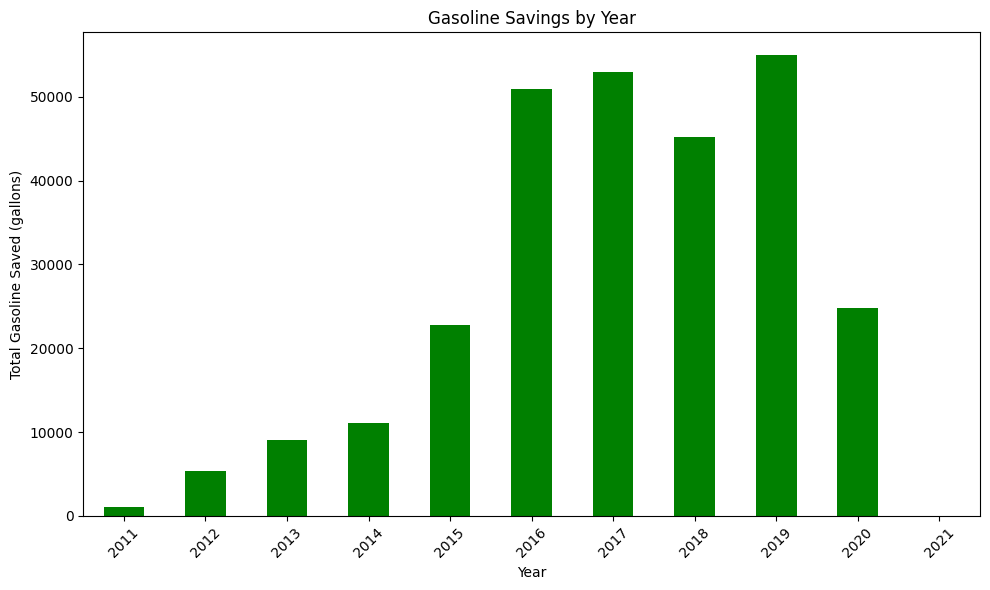

In [ ]:
gasoline_savings_by_year = df.groupby('Year')['Gasoline Savings (gallons)'].sum()


plt.figure(figsize=(10, 6))
gasoline_savings_by_year.plot(kind='bar', color='green')
plt.title('Gasoline Savings by Year')
plt.xlabel('Year')
plt.ylabel('Total Gasoline Saved (gallons)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

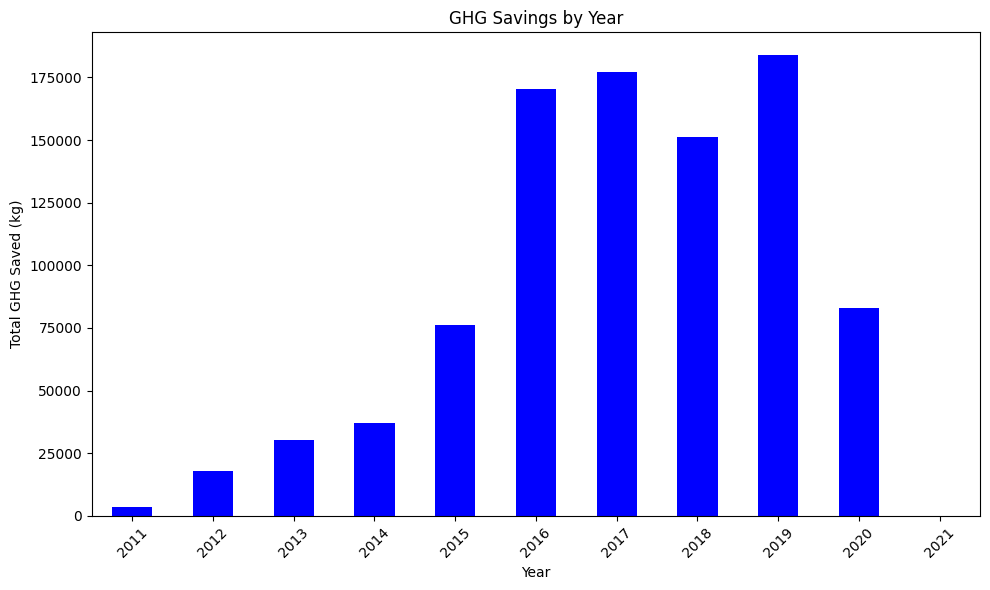

In [ ]:
ghg_savings_by_year = df.groupby('Year')['GHG Savings (kg)'].sum()


plt.figure(figsize=(10, 6))
ghg_savings_by_year.plot(kind='bar', color='blue')
plt.title('GHG Savings by Year')
plt.xlabel('Year')
plt.ylabel('Total GHG Saved (kg)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

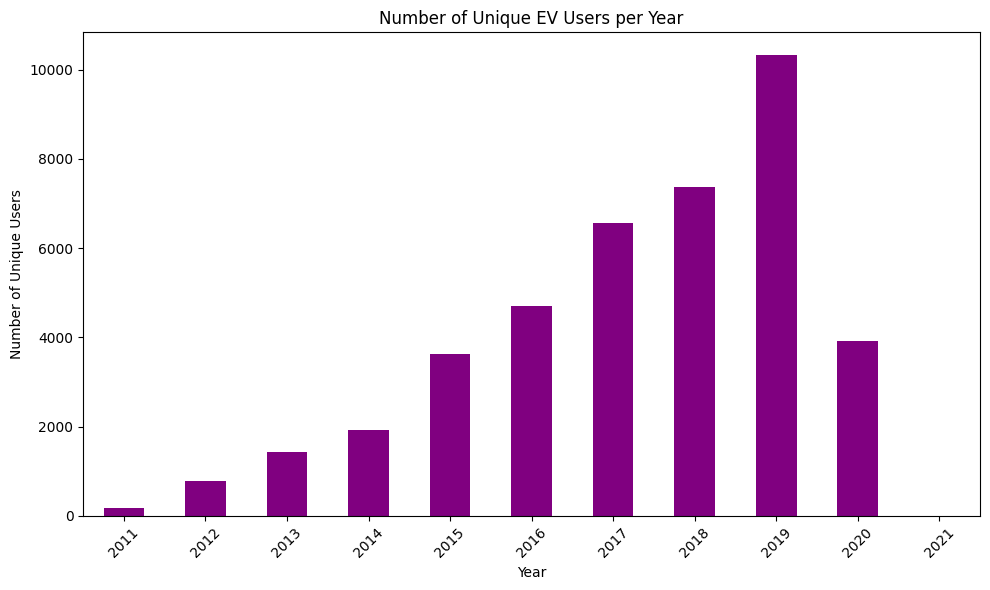

In [ ]:
unique_users_per_year = df.groupby('Year')['User ID'].nunique()

# Create a bar plot for unique EV users per year
plt.figure(figsize=(10, 6))
unique_users_per_year.plot(kind='bar', color='purple')
plt.title('Number of Unique EV Users per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Correlation
The correlation between GHG Savings,Energy Consumed and Gasoline Savings is very high which is quiet intutive.A highly accurate model can be created from it as the correlation value is very high and can be predicted using a straight line.

Whereas the correaltion between year and yearly GHG Savings,Energy Consumed Yearly and Yearly Gasoline savings is relatievly low which can be justified by non-linear behaviour (as observed from the graph) as well as the exceptions for the year 2018 and 2020.


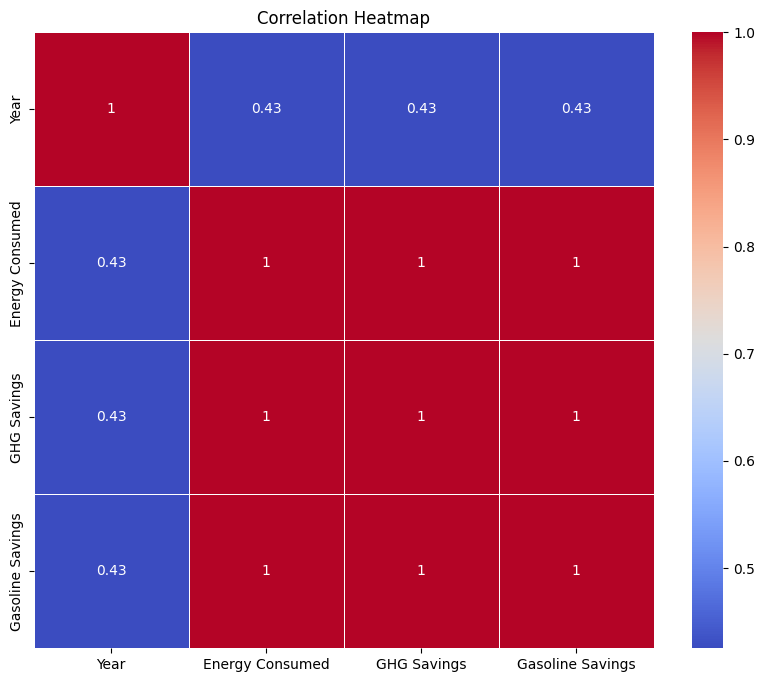

In [ ]:
yearly_energy_consumption = df.groupby('Year')['Energy (kWh)'].sum()
yearly_ghg_savings = df.groupby('Year')['GHG Savings (kg)'].sum()
yearly_gasoline_savings = df.groupby('Year')['Gasoline Savings (gallons)'].sum()

# Create a new DataFrame with the calculated yearly sums
yearly_data = pd.DataFrame({
    'Year': yearly_energy_consumption.index,
    'Energy Consumed': yearly_energy_consumption.values,
    'GHG Savings': yearly_ghg_savings.values,
    'Gasoline Savings': yearly_gasoline_savings.values
})

# Calculate the correlation matrix
correlation_matrix = yearly_data.corr()

# Create a heatmap to visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-33-b9afdb84778e>:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('data/EVChargingStationUsage.csv')


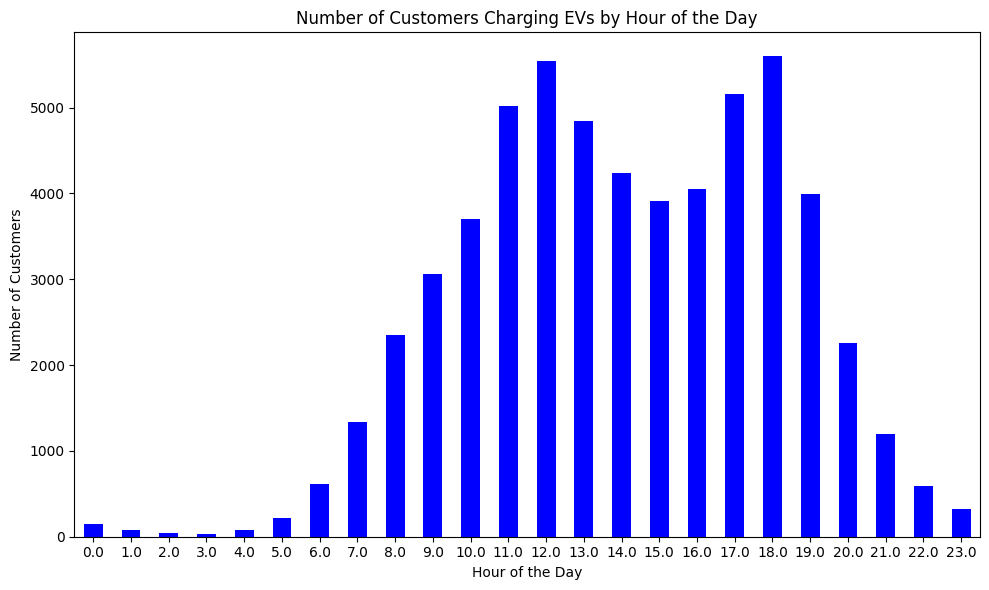

In [ ]:
df1 = pd.read_csv('data/EVChargingStationUsage.csv')
df1['Start Date'] = pd.to_datetime(df1['Start Date'], format='%m/%d/%Y %H:%M', errors='coerce')
df1['Start Date'] = df1['Start Date'].combine_first(pd.to_datetime(df1['Start Date'], format='%m-%d-%Y %H:%M:%S', errors='coerce'))
df1['Hour'] = df1['Start Date'].dt.hour

# Group the data by hour and count the number of unique customers (User IDs)
customers_by_hour = df1.groupby('Hour')['User ID'].nunique()

# Create a bar plot to visualize the number of customers by hour
plt.figure(figsize=(10, 6))
customers_by_hour.plot(kind='bar', color='blue')
plt.title('Number of Customers Charging EVs by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

**Note that the above graph has the local time zone as it would give us better visualization as compared to time being converted to UTC as there is a difference of 7 hourse between UTC and PDT.**

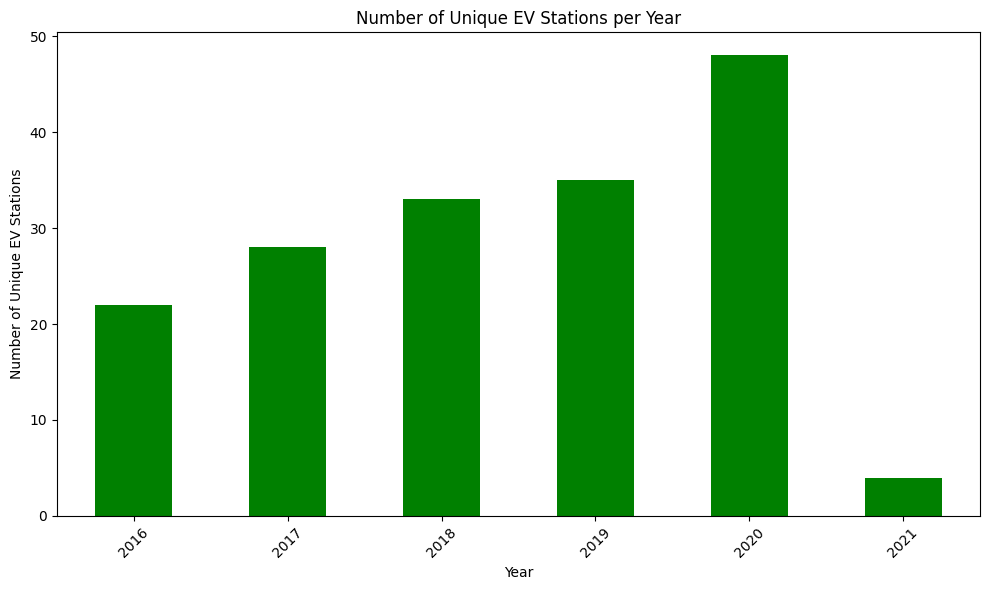

In [ ]:
unique_stations_per_year = df.groupby('Year')['EVSE ID'].nunique()

# Filter out years with zero unique EV stations
unique_stations_per_year = unique_stations_per_year[unique_stations_per_year != 0]

# Create a bar plot for the number of unique EV stations per year
plt.figure(figsize=(10, 6))
unique_stations_per_year.plot(kind='bar', color='green')
plt.title('Number of Unique EV Stations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique EV Stations')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**The above plot shows number of unique EV stations visited by customers each year.The increase in the number suggets opening of new EV stations which would ultimately help in decreasing the waiting time.**